**🚨  This is a shorter version of [Making_maps_with_ML.ipynb](Making_maps_with_ML.ipynb)**

The other version has some content on SciPy's RBF interpolator.

# Making maps

I'm using a small dataset originally from [**Geoff Bohling**](http://people.ku.edu/~gbohling/) at the Kansas Geological Survey. I can no longer find the data online, but here's what he says about it:

> Our example data consist of vertically averaged porosity values, in percent, in Zone A of the Big Bean Oil Field (fictitious, but based on real data). Porosity values are available from 85 wells distributed throughout the field, which is approximately 20 km in east-west extent and 16 km north-south. The porosities range from 12% to 17%.

[Read more about it](http://discoverspatial.in/wp-content/uploads/2018/04/IntroToGeostatistics-Geoff-Bohling.pdf)

There are various ways to interpolate data like this, for example:

- Using SciPy with `scipy.interpolate.Rbf`
- Using the Scikit-Learn machine learning library with `sklearn.gaussian_process`
- Using the library [`verde`](https://github.com/fatiando/verde)

In this notebook, we focus on the machine learning approach.

## Load and inspect the data

### EXERCISE

The data file is on the web at `https://www.dropbox.com/s/6dyfc4fl5slhgry/ZoneA.dat?raw=1` and `https://geocomp.s3.amazonaws.com/data/ZoneA.dat`.

Load the data from the text file into a Pandas DataFrame. <a title="Use Pandas's read_csv() method. You will need to set some arguments: sep, header, usecols, names, and dtype."><b>Hover for HINT</b></a>

We don't need all of the fields, but we at least need x, y, thickness and porosity. The top of the DataFrame should look something like this:

              x       y     thick       por
    0   12100.0  8300.0   37.1531   14.6515
    1    5300.0  8700.0   31.4993   14.5093
    
Once you have the data, can you make a KDE plot (`sns.kdeplot()`) with Seaborn?

In [1]:
# YOUR CODE HERE
fname = "https://geocomp.s3.amazonaws.com/data/ZoneA.dat"



In [2]:
import pandas as pd

fname = "https://geocomp.s3.amazonaws.com/data/ZoneA.dat"

df = pd.read_csv(fname,
                 sep=' ',
                 header=9,
                 usecols=[0, 1, 2, 3, 4],
                 names=['x', 'y', 'thick', 'por', 'perm'],
                 dtype="float64",
                 na_values=[-999.9999],
                )

df.head()

,x,y,thick,por,perm
0,12100.0,8300.0,37.1531,14.6515,2.8547
1,5300.0,8700.0,31.4993,14.5093,NaN
2,3500.0,13900.0,36.9185,14.0639,NaN
3,5100.0,1900.0,24.0156,15.1084,1.1407
4,9900.0,13700.0,35.0411,13.9190,NaN


<AxesSubplot:xlabel='por', ylabel='Density'>

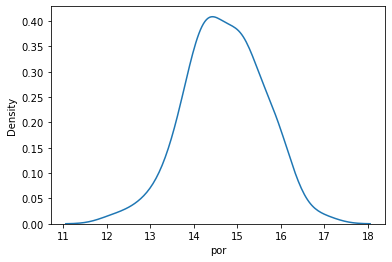

In [3]:
import seaborn as sns

sns.kdeplot(df.por)

This looks a bit unpleasant, but we're just getting out min and max values for the x and y columns.

In [4]:
extent = x_min, x_max, y_min, y_max = [df.x.min()-1000, df.x.max()+1000,
                                       df.y.min()-1000, df.y.max()+1000]

Later on, we'll see a nicer way to do this using the Verde library.

Now we can plot the data:

### EXERCISE

Make a map of the porosity data. Use the colour of the points to indicate porosity, and use the size to indicate thickness of the zone.

Add a colourbar, title, and other annotation.

In [5]:
# YOUR CODE HERE



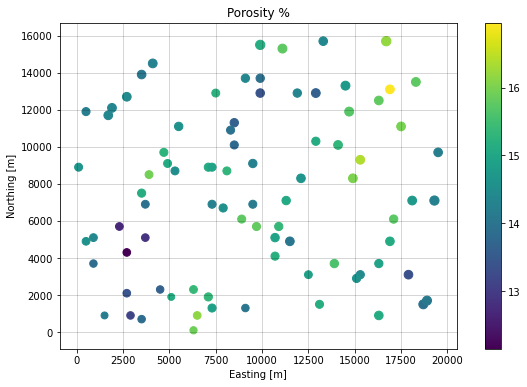

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))

scatter = ax.scatter(df.x, df.y, c=df.por, s=2*df.thick)
plt.colorbar(scatter)
ax.set_aspect(1)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Porosity %')
ax.grid(c='k', alpha=0.2)

plt.show()

## Make a regular grid

We must make a grid, which represents the points we'd like to predict.

In [8]:
import numpy as np

# Notice the order of x (columns) and y (rows)!
grid_y, grid_x = np.mgrid[y_min:y_max:500, x_min:x_max:500]

# Use *shape* argument to specify the *number* (not size) of bins:
# grid_y, grid_x = np.mgrid[y_min:y_max:100j, x_min:x_max:100j]

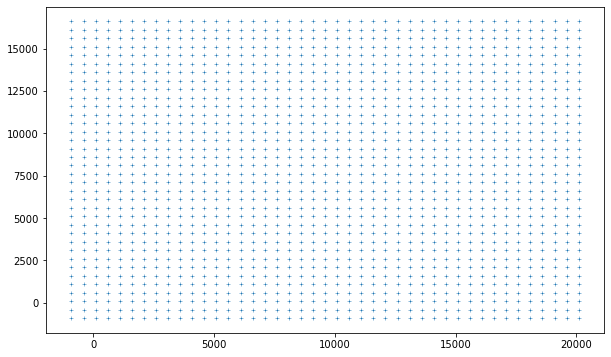

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(grid_x, grid_y, marker='+', lw=0.5, s=10)

That was easy!

----

## Interpolating with machine learning

Interpolation is a kind of regression (and, arguably, all prediction is interpolation... so all machine learning models are maps). And we have a bunch of different nonlinear regressors available to us in `scikit-learn`. So let's apply some of them to our problem.

We'll start with a Gaussian process model, which is the basis of the popular gridding approach **kriging**.

### Using `sklearn.gaussian_process`

Modeling with a Gaussian process is equivalent to kriging. Conveniently, the popular machine learning library `scikit-learn` has a Gaussian process modeling tool.

In [10]:
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1000)

The main hyperparameters are the kernel, which we just defined, and `alpha`, which controls the smoothness. Larger values imply mmore noise in the input data, and result in smoother grids; default is very small: 1 &times; 10<sup>-9</sup>.

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(normalize_y=True,
                              alpha=0.1,  # Larger values imply more noise in the input data.
                              kernel=kernel,)

gp.fit(df[['x', 'y']].values, df.por.values)

GaussianProcessRegressor(alpha=0.1, kernel=RBF(length_scale=1e+03),
                         normalize_y=True)

To make a prediction, we need to construct the X matrix: (x, y) coordinates in 2 columns:

In [12]:
X_grid = np.stack([grid_x.ravel(), grid_y.ravel()]).T

Now we can make a prediction:

In [13]:
y_grid = gp.predict(X_grid).reshape(grid_x.shape)

And plot the predicted grid with the input data using the same colourmap:

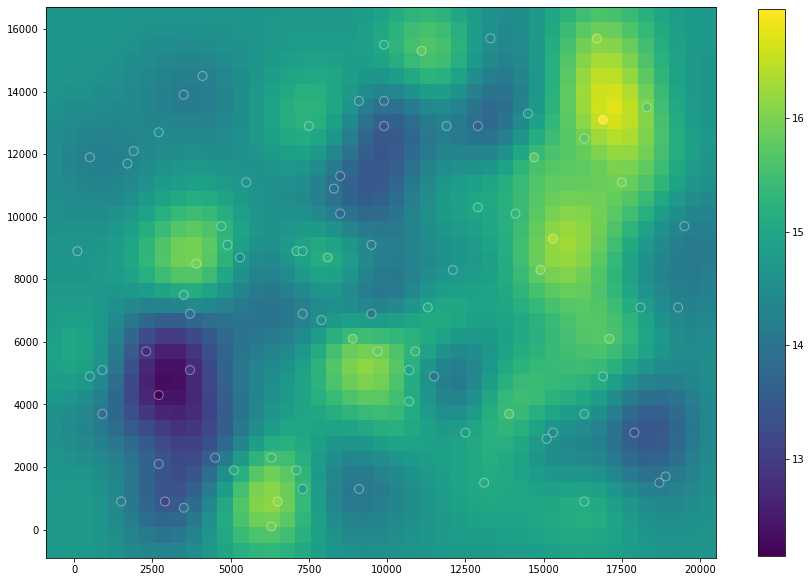

In [14]:
# Compute min and max of all the data:
mi = np.min(np.hstack([y_grid.ravel(), df.por.values]))
ma = np.max(np.hstack([y_grid.ravel(), df.por.values]))

# Plot it all.
plt.figure(figsize=(15,15))
im = plt.imshow(y_grid, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

### EXERCISE

- Can you make a prediction on the original (x, y) values from the dataframe?
- Compute the residuals by comparing to the actual measured porosities at those locations.
- Make a KDE plot of the residuals.

In [ ]:
# YOUR CODE HERE



<AxesSubplot:xlabel='por', ylabel='Density'>

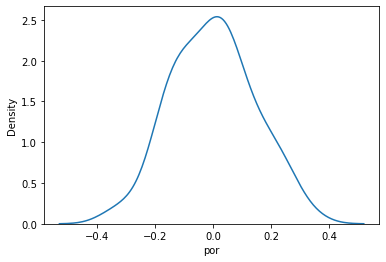

In [17]:
por_hat = gp.predict(df[['x', 'y']].values)

sns.kdeplot(por_hat - df.por)

In [20]:
# Put the prediction in the dataframe for later.
df['por_GP'] = gp.predict(df[['x', 'y']].values)

## Going further

The GP model actually models the distribution, not just the mean (which is also the most likely or mode and the P50 or median, for a normal distribution). So we can also look at a sample from the distribution:

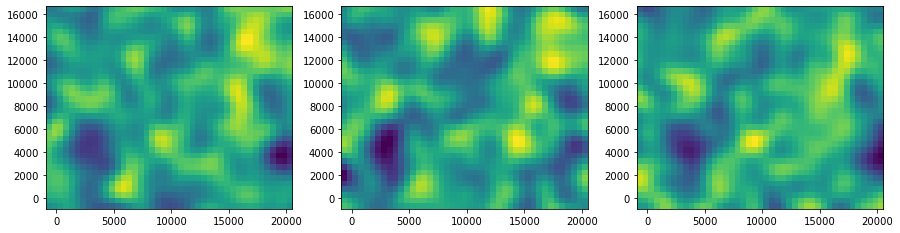

In [21]:
y_sample = gp.sample_y(X_grid, n_samples=3, random_state=42)

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
for ax, y_hat in zip(axs, y_sample.T):
    im = ax.imshow(y_hat.reshape(grid_x.shape), origin='lower', extent=extent)
plt.show()

Let's look at a cross-section.

We'll want the 'wells' on there at some point, so let's add grid-cell coordinates. (A better way to do this would be to use `xarray`.)

In [22]:
df['x_grid'] = (df.x - x_min) // 500
df['y_grid'] = (df.y - y_min) // 500

Now we can get the mean and stdev of the prediction:

In [23]:
y_grid, y_std = gp.predict(X_grid, return_std=True)

y_grid = y_grid.reshape(grid_x.shape)
y_std = y_std.reshape(grid_x.shape)

Then choose a row to look at, and filter the wells down to near that row:

In [24]:
row = 19
wells = df[abs(df.y_grid - row) <= 1]

Let's check where that row and its wells are:

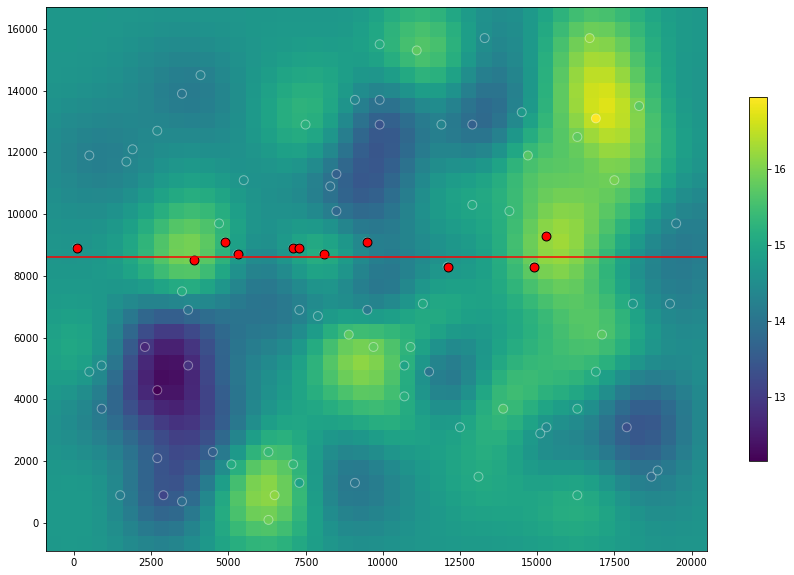

In [25]:
plt.figure(figsize=(15, 10))
im = plt.imshow(y_grid, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
pts = plt.scatter(wells.x, wells.y, c='r', s=80, edgecolor='k')
plt.colorbar(im, shrink=0.67)
plt.axhline(y_min + 19 * 500, c='red')
plt.show()

And compute various things:

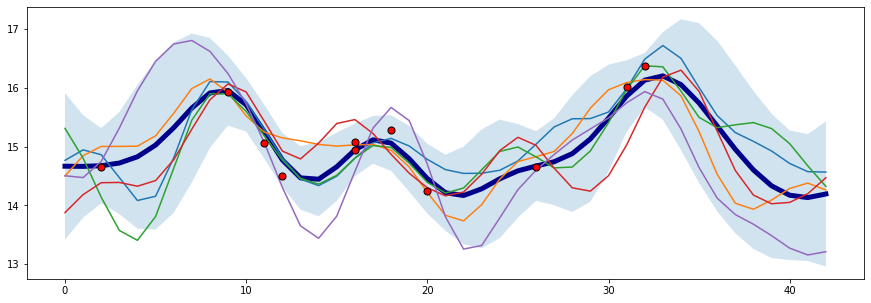

In [26]:
# Confidence interval.
phi, s = y_grid[row], y_std[row]
max_ = phi - 1.96 * s  # 95% confidence interval
min_ = phi + 1.96 * s  #     = 1.96 * stdev

# Draw some samples.
y_samples = gp.sample_y(X_grid, n_samples=5)

# Plot.
plt.figure(figsize=(15, 5))
for i, well in wells.iterrows():
    plt.scatter(well.x_grid, well.por, c='red', ec='k', s=50, zorder=100)
plt.plot(phi, c='darkblue', lw=5)
for sample in y_samples.T:
    plt.plot(sample.reshape(grid_x.shape)[row])
plt.fill_between(range(phi.size), min_, max_, alpha=0.2)
plt.show()

## More models!

### EXERCISE

Try some other regressors in `scikit-learn`. Look at the maps they produce, and check their residuals. (You might want to write a loop to check several models.)

Which regressors produce the best maps? 

In [27]:
# YOUR CODE HERE



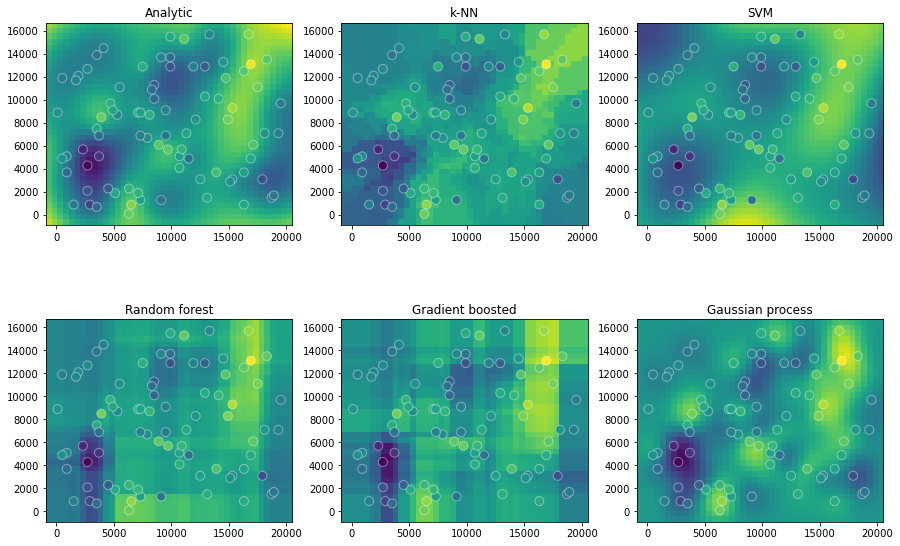

In [28]:
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from scipy.interpolate import Rbf


models =  {
    'Analytic': Rbf(df.x, df.y, df.por, smooth=0.1, function='multiquadric'), # Not an sklearn model!
    'k-NN': KNeighborsRegressor(n_neighbors=5),
    'SVM': SVR(C=10),
    'Random forest': RandomForestRegressor(max_depth=7),
    'Gradient boosted': HistGradientBoostingRegressor(min_samples_leaf=5),
    'Gaussian process': GaussianProcessRegressor(normalize_y=True, alpha=0.1, kernel=kernel),
}

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

for (model, regr), ax in zip(models.items(), axs.ravel()):
    if model == 'Analytic':
        y_grid = regr(grid_x, grid_y)  # scipy provides a function here.
    else:
        regr.fit(df[['x', 'y']].values, df.por.values)
        y_grid = regr.predict(X_grid).reshape(grid_x.shape)
    
    mi = np.min(np.hstack([y_grid.ravel(), df.por.values]))
    ma = np.max(np.hstack([y_grid.ravel(), df.por.values]))

    im = ax.imshow(y_grid, origin='lower', cmap='viridis', extent=extent, vmin=mi, vmax=ma)
    pts = ax.scatter(df.x, df.y, c=df.por, s=80, cmap='viridis', edgecolor='#ffffff66', vmin=mi, vmax=ma)
    ax.set_title(model)

plt.show()

## Superpowers with `verde`

The geophysical package `verde` contains still more gridding algorithms, and makes some aspects of the gridding much easier — for example reducing the nuber of points in the dataset in sensible ways. [Read about it.](https://www.leouieda.com/blog/introducing-verde.html)

### Using verde.Spline

One of the options in scipy's Rbf interpolator is the "thin-plate" kernel. This is what the `verde.Spline` interpolator is based on but with a few modifications, like damping regularization to smooth the solution. It's similar to the `RBF` and `GaussianProcessRegressor` approach but Verde provides a more convenient API for gridding tasks.

For example, we now have a nicer way to define extent, using `vd.pad_region()`:

In [30]:
import verde as vd

extent = x_min, x_max, y_min, y_max = vd.pad_region(vd.get_region((df.x, df.y)), pad=1000)

The API is partially based on that of `sklearn`:

In [31]:
spline = vd.Spline(mindist=2000, damping=1e-4)
spline.fit((df.x, df.y), df.por)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Spline(damping=0.0001, mindist=2000)

To make a grid, use the `.grid()` method of the spline:

In [32]:
grid = spline.grid(region=extent, spacing=500)
grid

<xarray.Dataset>
Dimensions:   (northing: 36, easting: 44)
Coordinates:
  * easting   (easting) float64 -900.0 -402.3 95.35 ... 1.95e+04 2e+04 2.05e+04
  * northing  (northing) float64 -900.0 -397.1 105.7 ... 1.62e+04 1.67e+04
Data variables:
    scalars   (northing, easting) float64 14.93 14.83 14.73 ... 16.17 16.18 16.2
Attributes:
    metadata:  Generated by Spline(damping=0.0001, mindist=2000)

This returns an `xarray.Dataset` which can be easily plotted, saved to disk as netCDF, or used for computations. The coordinates for the grid are automatically generated and populated based on the desired region and spacing. The spacing is adjusted to fit the desired region exactly. Optionally, you can set `adjust="region"` to adjust the size of the region so that the spacing is exact.

And plot the predicted grid with the input data using the same colourmap:

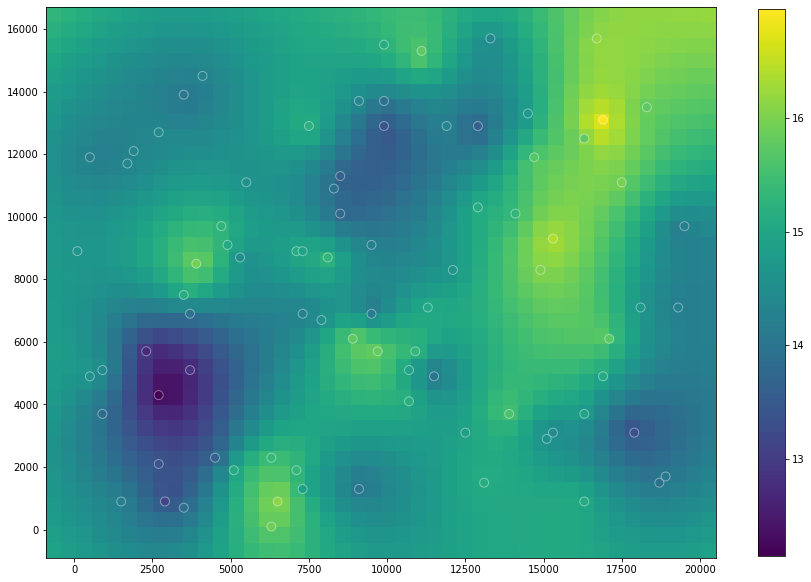

In [33]:
# Compute min and max of all the data:
mi = np.min(np.hstack([grid.scalars.values.ravel(), df.por.values]))
ma = np.max(np.hstack([grid.scalars.values.ravel(), df.por.values]))

# Plot it all.
plt.figure(figsize=(15,15))
im = plt.imshow(grid.scalars, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

As before, we can compute the error by making a prediction on the original (x, y) values and comparing to the actual measured porosities at those locations:

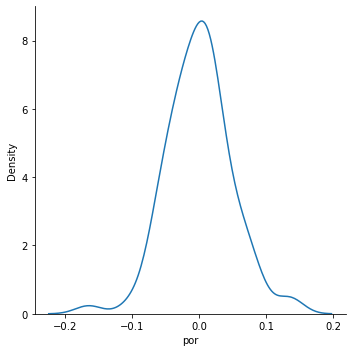

In [35]:
por_hat = spline.predict((df.x, df.y))

sns.displot(por_hat - df.por, kind='kde')

## Geostatistical approaches

The geostatistical package `gstools` implements various kriging algorithms, which some people may be more familiar with. [Check it out](https://github.com/GeoStat-Framework/GSTools). 

----

<center>&copy; 2022 Agile Scientific, licensed CC-BY</center>